In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, util, plot_style

In [2]:
import os

print(os.getcwd())

c:\Users\caele\Documents\miller-lab-final\figures\figure7


In [7]:
# task parameters
numPairs = 5
dt = 1e-5
seq_len = 6
sequences = lrt.make_all_sequences(seq_len, ['L', 'R'])
equil_duration = 2

In [68]:
# load reliabilities
reliabilities = np.load('data_1/reliabilities.npy', allow_pickle=True)
print(reliabilities.shape)

(1000,)


### Psychometric curves

In [12]:
import scipy

In [5]:
# load p_curves
data = np.load('data_1/p_curves.npy', allow_pickle=True)
data.shape

(1000, 7)

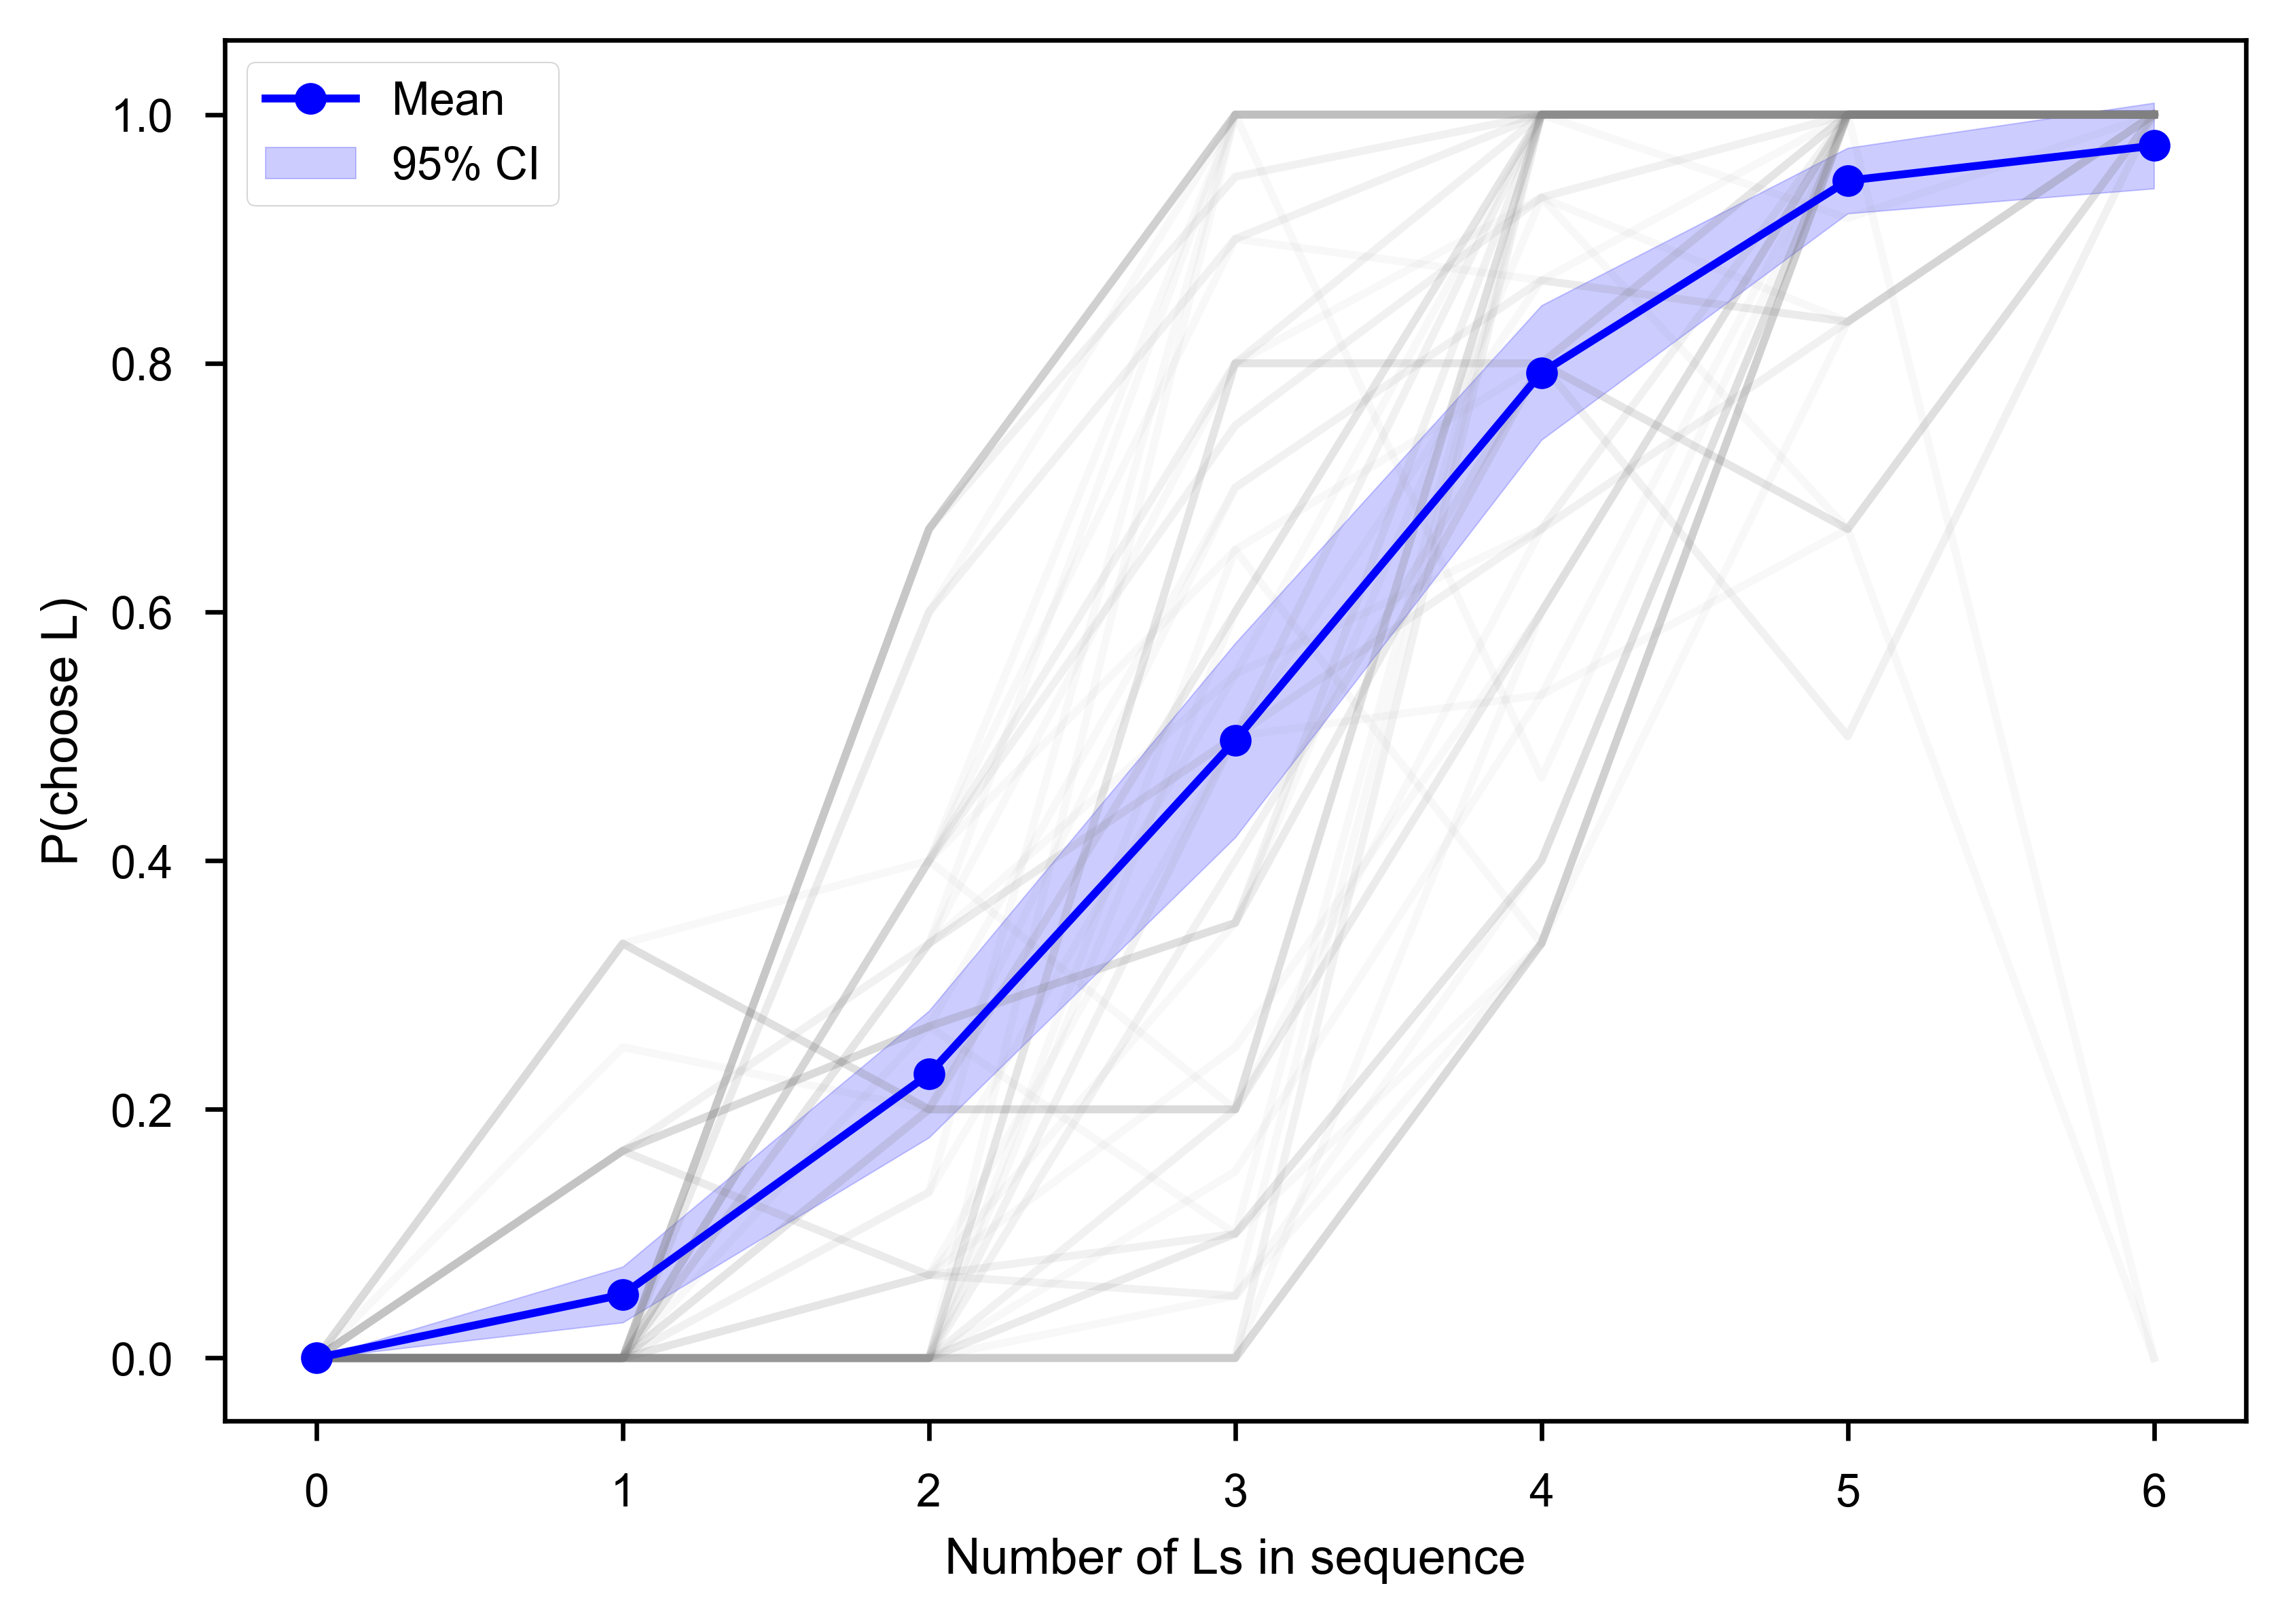

In [ ]:
good_p_curves = data[reliabilities > 0.73]
plt.plot(np.arange(seq_len + 1), good_p_curves.T, color='gray', alpha=0.05)
mean_p = np.mean(good_p_curves, axis=0)
sem_p = scipy.stats.sem(good_p_curves, axis=0)
plt.plot(np.arange(seq_len + 1), mean_p, '-o', color='blue', label='Mean')
plt.fill_between(np.arange(seq_len + 1), mean_p - 1.96 * sem_p, mean_p + 1.96 * sem_p, color='blue', alpha=0.2, label='95% CI')
plt.legend()
plt.xlabel('Number of Ls in sequence')
plt.ylabel('P(choose L)')
plt.show()

### Recency + primacy

In [3]:
# load data from csv to df
df_decisions = pd.read_csv('data_1/decision_dict.csv', index_col=0)
df_decisions.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
LLLRRR,R,Tie,R,Tie,R,Tie,Tie,L,R,R,...,R,L,Tie,Tie,R,Tie,R,R,R,R
LLRRRR,R,Tie,R,Tie,R,Tie,Tie,R,R,R,...,R,L,Tie,Tie,L,Tie,R,R,R,R
LRLRRR,R,Tie,R,Tie,R,Tie,Tie,L,R,R,...,R,L,Tie,Tie,R,Tie,R,R,R,R
LRRLRR,R,Tie,R,Tie,R,Tie,Tie,L,R,R,...,R,L,Tie,Tie,L,Tie,R,R,R,R
LRRRLR,R,Tie,R,Tie,R,Tie,Tie,L,R,R,...,R,L,Tie,Tie,R,Tie,R,R,R,R


In [102]:
# recover kernels
n_trials = 1000
r_kernels = np.zeros((n_trials, numPairs))
l_kernels = np.zeros((n_trials, numPairs))

for i in range(n_trials):
    rng = np.random.default_rng(i)
    
    # make kernels -- same mean
    l_kernel = rng.lognormal(0, 1, numPairs)
    l_kernel = l_kernel / np.sum(l_kernel) * numPairs
    l_kernel = np.round(l_kernel, 5)
    r_kernel = rng.lognormal(0, 1, numPairs)
    r_kernel = r_kernel / np.sum(r_kernel) * numPairs
    r_kernel = np.round(r_kernel, 5)

    r_kernels[i] = r_kernel
    l_kernels[i] = l_kernel

kernel_means = (np.mean(l_kernels, axis=1) + np.mean(r_kernels, axis=1)) / 2
kernel_dot = np.sum(l_kernels * r_kernels, axis=1)
print(r_kernels.shape, l_kernels.shape)

(1000, 5) (1000, 5)


#### New method

In [70]:
reliabilities.shape

(1000,)

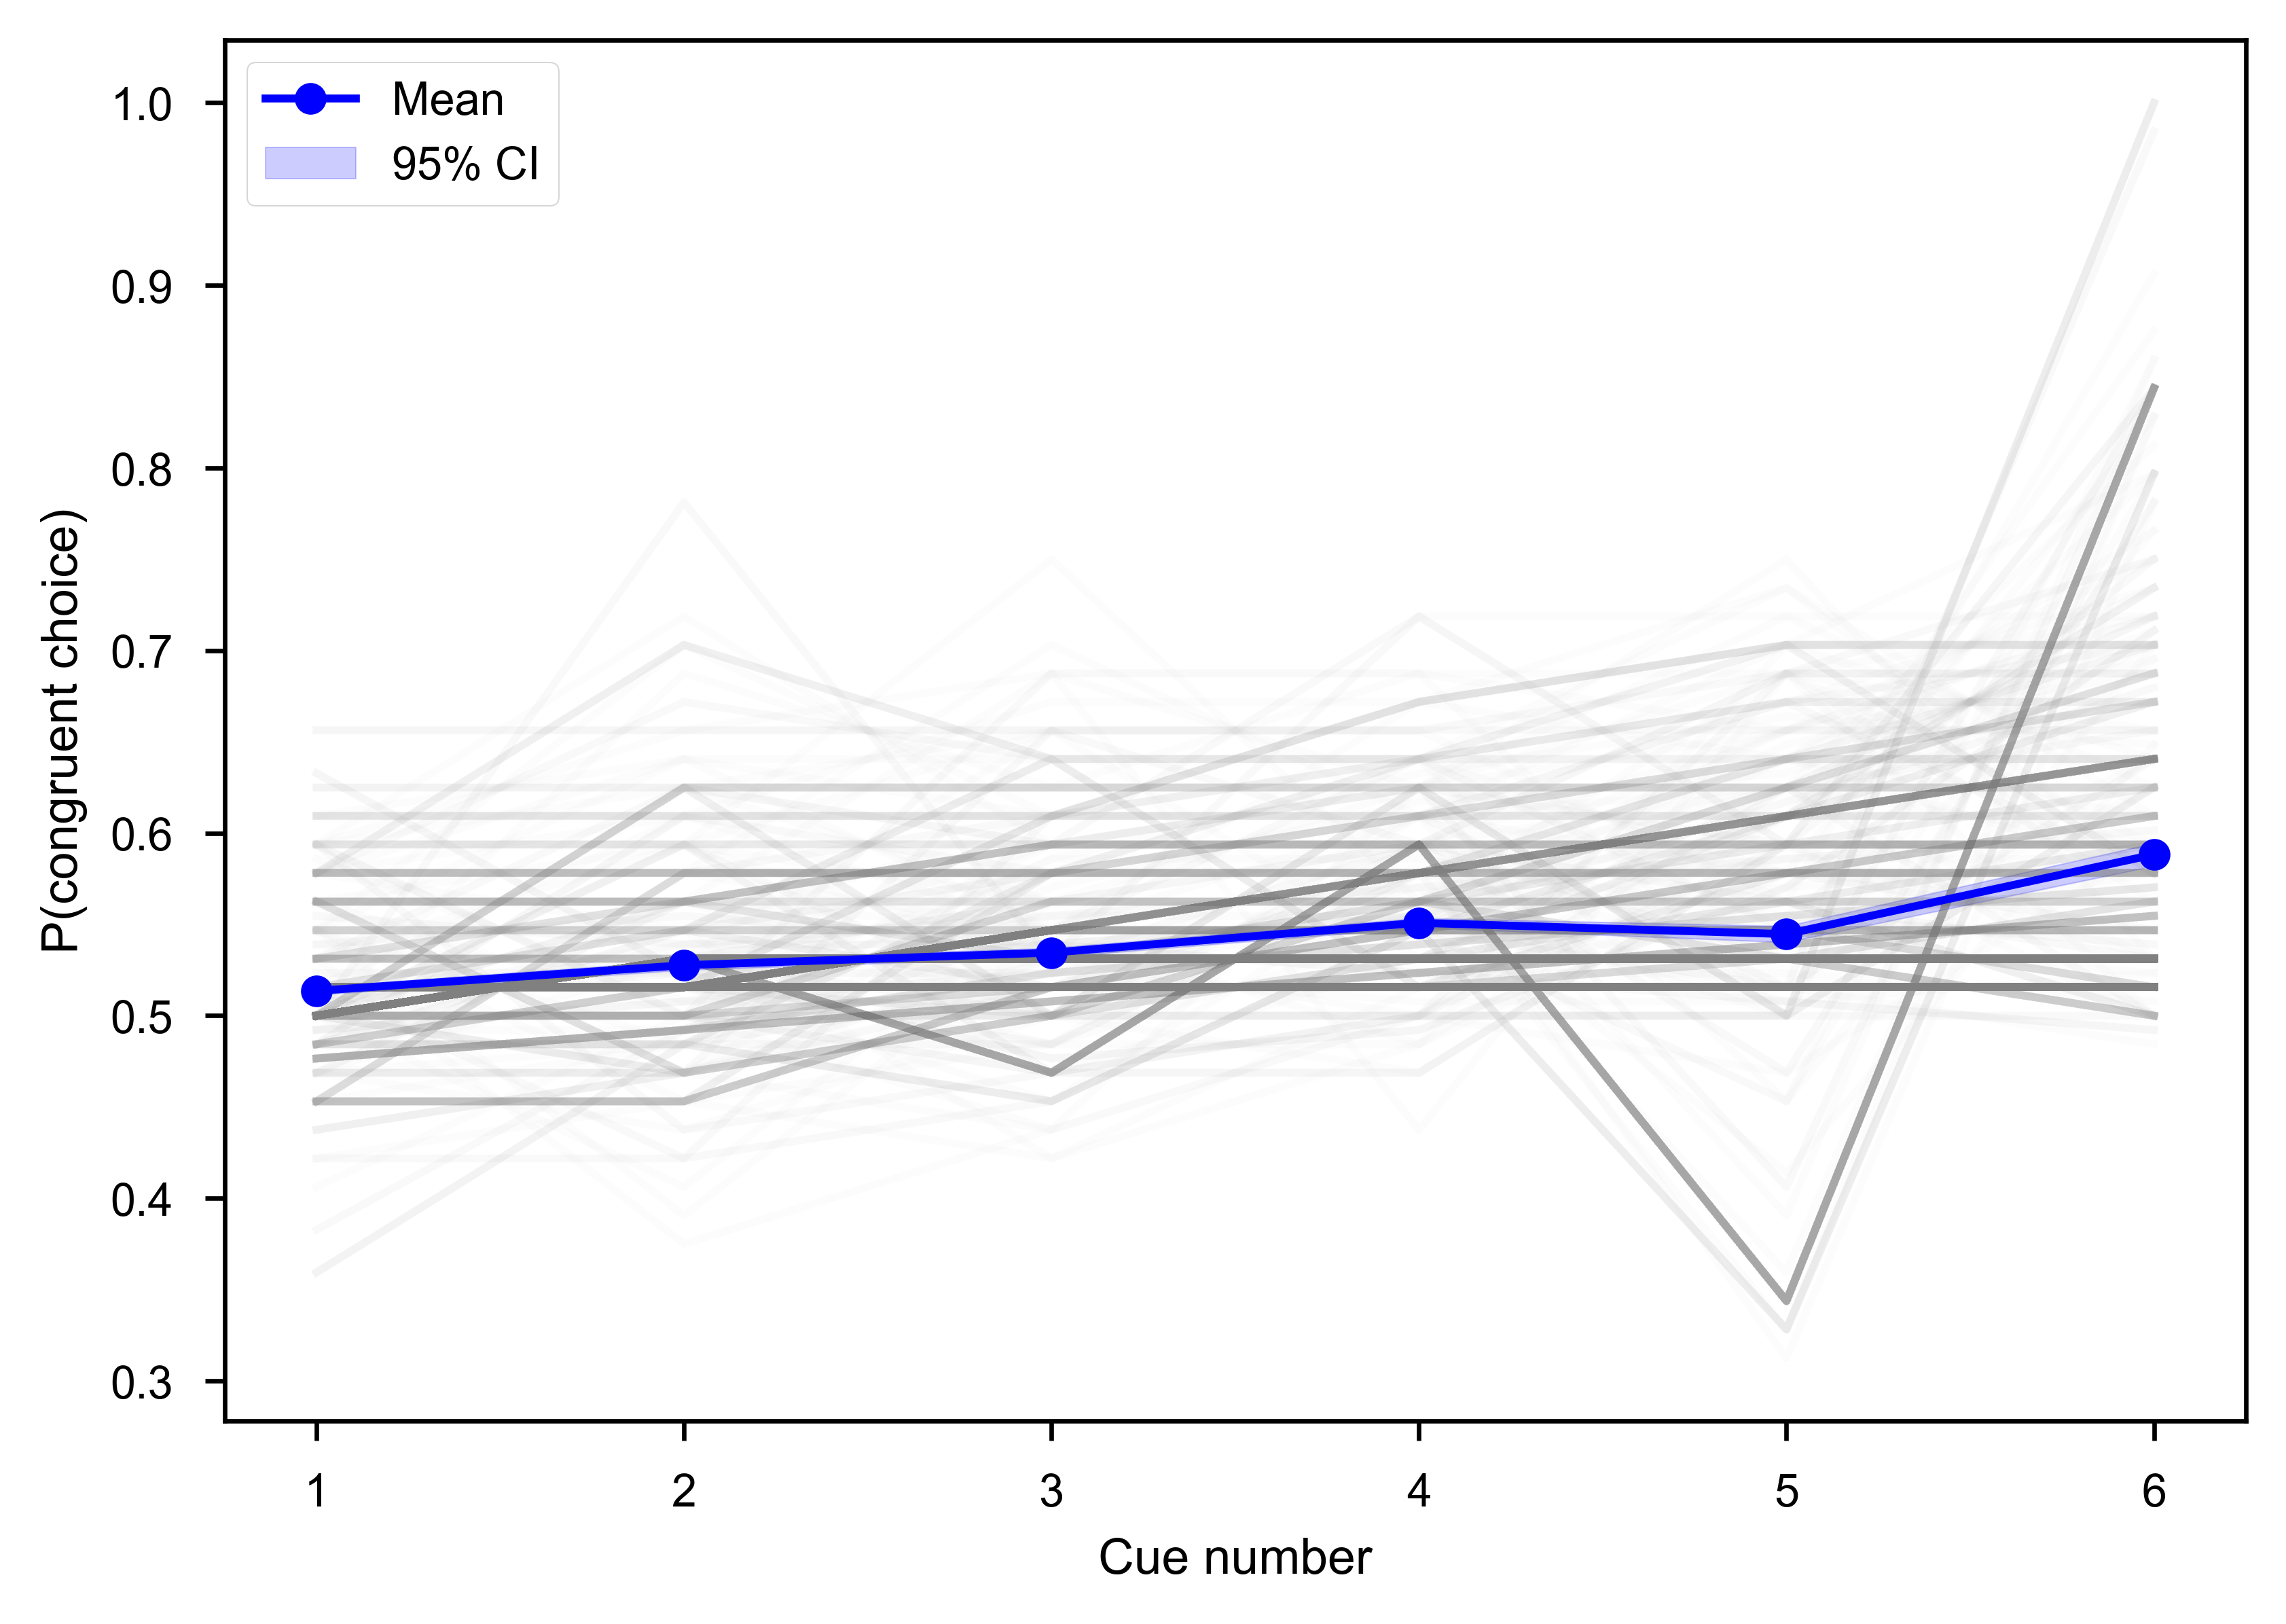

In [98]:
# probability of congruent choice given cue position and cue identity
threshold = 0.5
prob_congruent = np.zeros((seq_len, len(df_decisions.columns))) # rows: position in sequence, cols: different networks
for i in range(seq_len):
    cue = [s[i] for s in df_decisions.index]
    for j, col in enumerate(df_decisions.columns):
        decisions = df_decisions[col].values
        congruent = [0.5 if d == 'Tie' else (1 if (d == c) else 0) for c, d in zip(cue, decisions)]
        prob_congruent[i, j] = np.mean(congruent)

prob_congruent = prob_congruent[:, reliabilities > threshold]
plt.plot(np.arange(seq_len) + 1, prob_congruent, color='gray', alpha=0.02)
plt.plot(np.arange(seq_len) + 1, np.mean(prob_congruent, axis=1), '-o', color='blue', label='Mean')
sem_pc = scipy.stats.sem(prob_congruent, axis=1)
plt.fill_between(np.arange(seq_len) + 1, np.mean(prob_congruent, axis=1) - 1.96 * sem_pc, np.mean(prob_congruent, axis=1) + 1.96 * sem_pc, color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Cue number')
plt.ylabel('P(congruent choice)')
plt.legend()
plt.show()

Text(0.5, 0, 'Slope of P(congruent choice)')

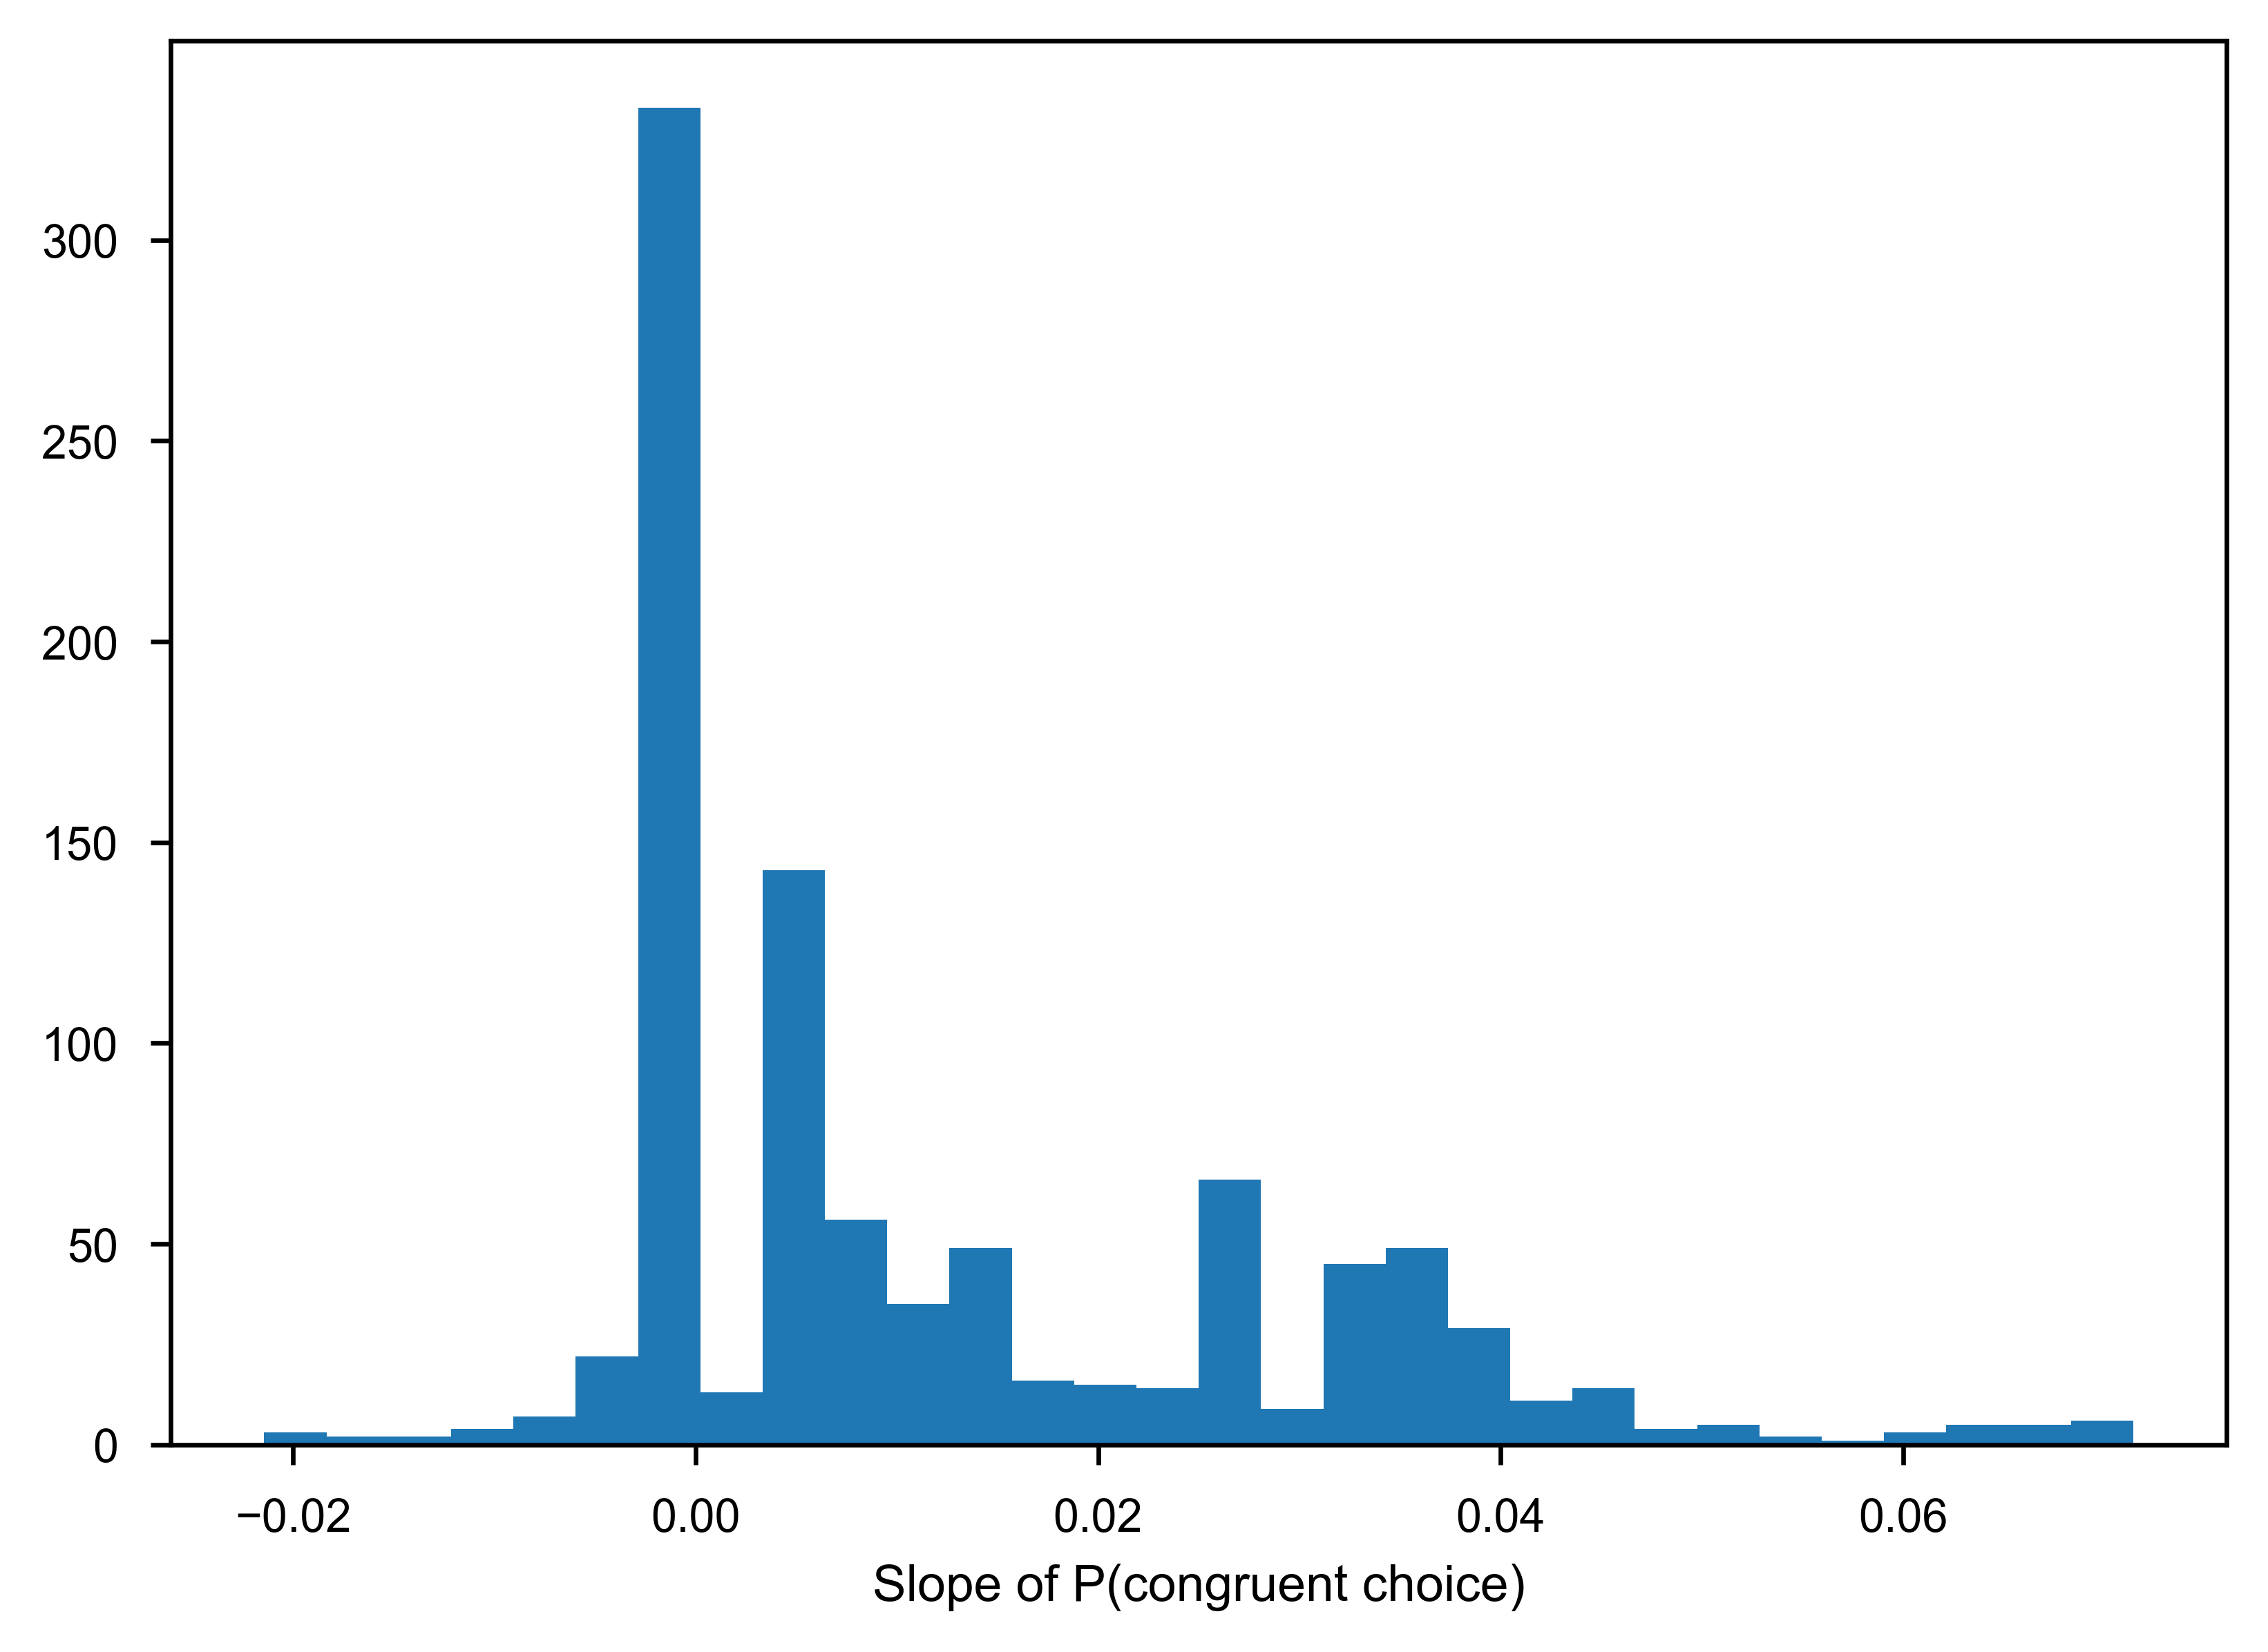

In [99]:
# compute average slope of each row in prob_congruent
slopes = np.zeros(prob_congruent.shape[1])
for j in range(prob_congruent.shape[1]):
    slopes[j] = np.polyfit(np.arange(seq_len) + 1, prob_congruent[:, j], 1)[0]
plt.hist(slopes, bins=30)
plt.xlabel('Slope of P(congruent choice)')

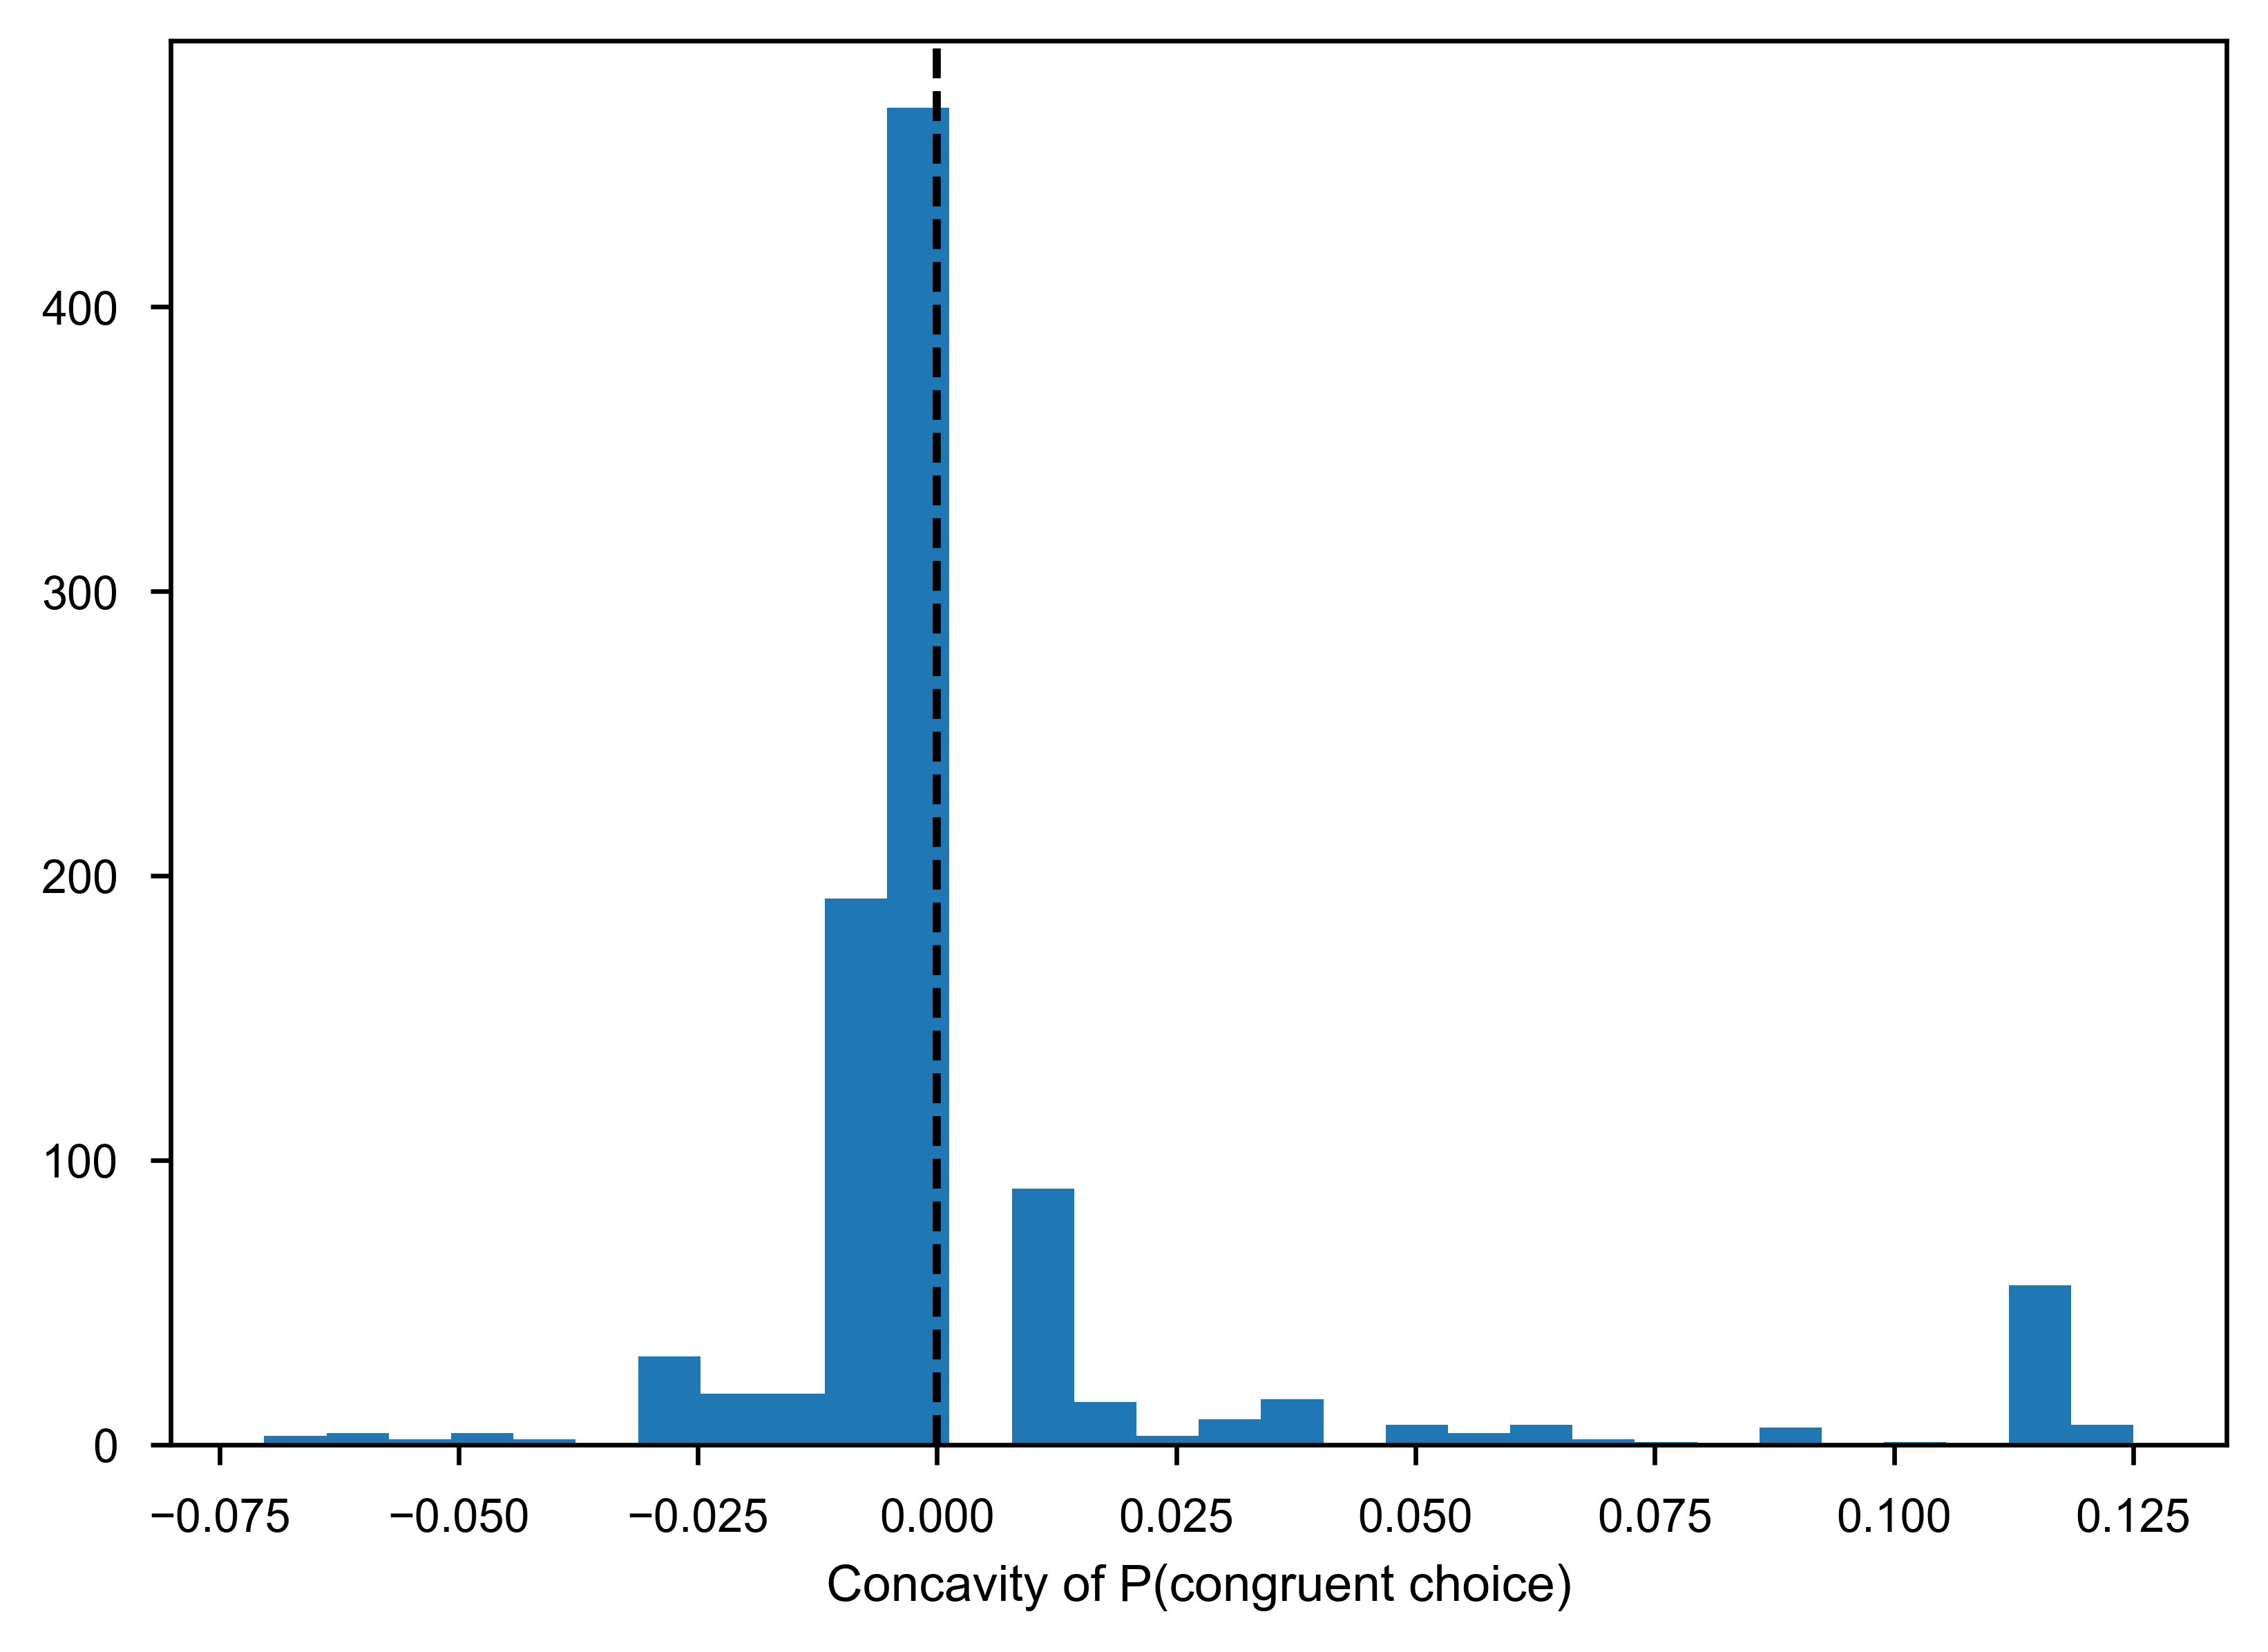

In [100]:
# compute concavity of each row in prob_congruent
concavities = np.zeros(prob_congruent.shape[1])
for j in range(prob_congruent.shape[1]):
    # compute second derivative using finite differences
    second_deriv = np.diff(prob_congruent[:, j], n=2)
    concavities[j] = np.mean(second_deriv)

plt.hist(concavities, bins=30)
plt.xlabel('Concavity of P(congruent choice)')
plt.axvline(0, color='black', linestyle='--')
plt.show()


#### Old method

In [63]:
correlations = np.zeros((seq_len, len(df_decisions.columns))) # rows: position in sequence, cols: different networks
for i in range(seq_len):
    cue = [s[i] for s in df_decisions.index]
    num_cue = [1 if c == 'L' else -1 for c in cue]
    for j, col in enumerate(df_decisions.columns):
        decision = [1 if d == 'L' else (-1 if d == 'R' else 0) for d in df_decisions[col].values]
        correlations[i, j] = np.corrcoef(num_cue, decision)[0, 1]
correlations.shape

(6, 1000)

In [64]:
# remove all rows with NaNs
nan_corrs = np.isnan(correlations).any(axis=0)
correlations = correlations[:, ~nan_corrs]
good_indices = np.where(reliabilities[~nan_corrs] > 0.98)[0]
l_kernels = l_kernels[~nan_corrs]
r_kernels = r_kernels[~nan_corrs]
print(np.isnan(correlations).sum())
correlations.shape

0


(6, 968)

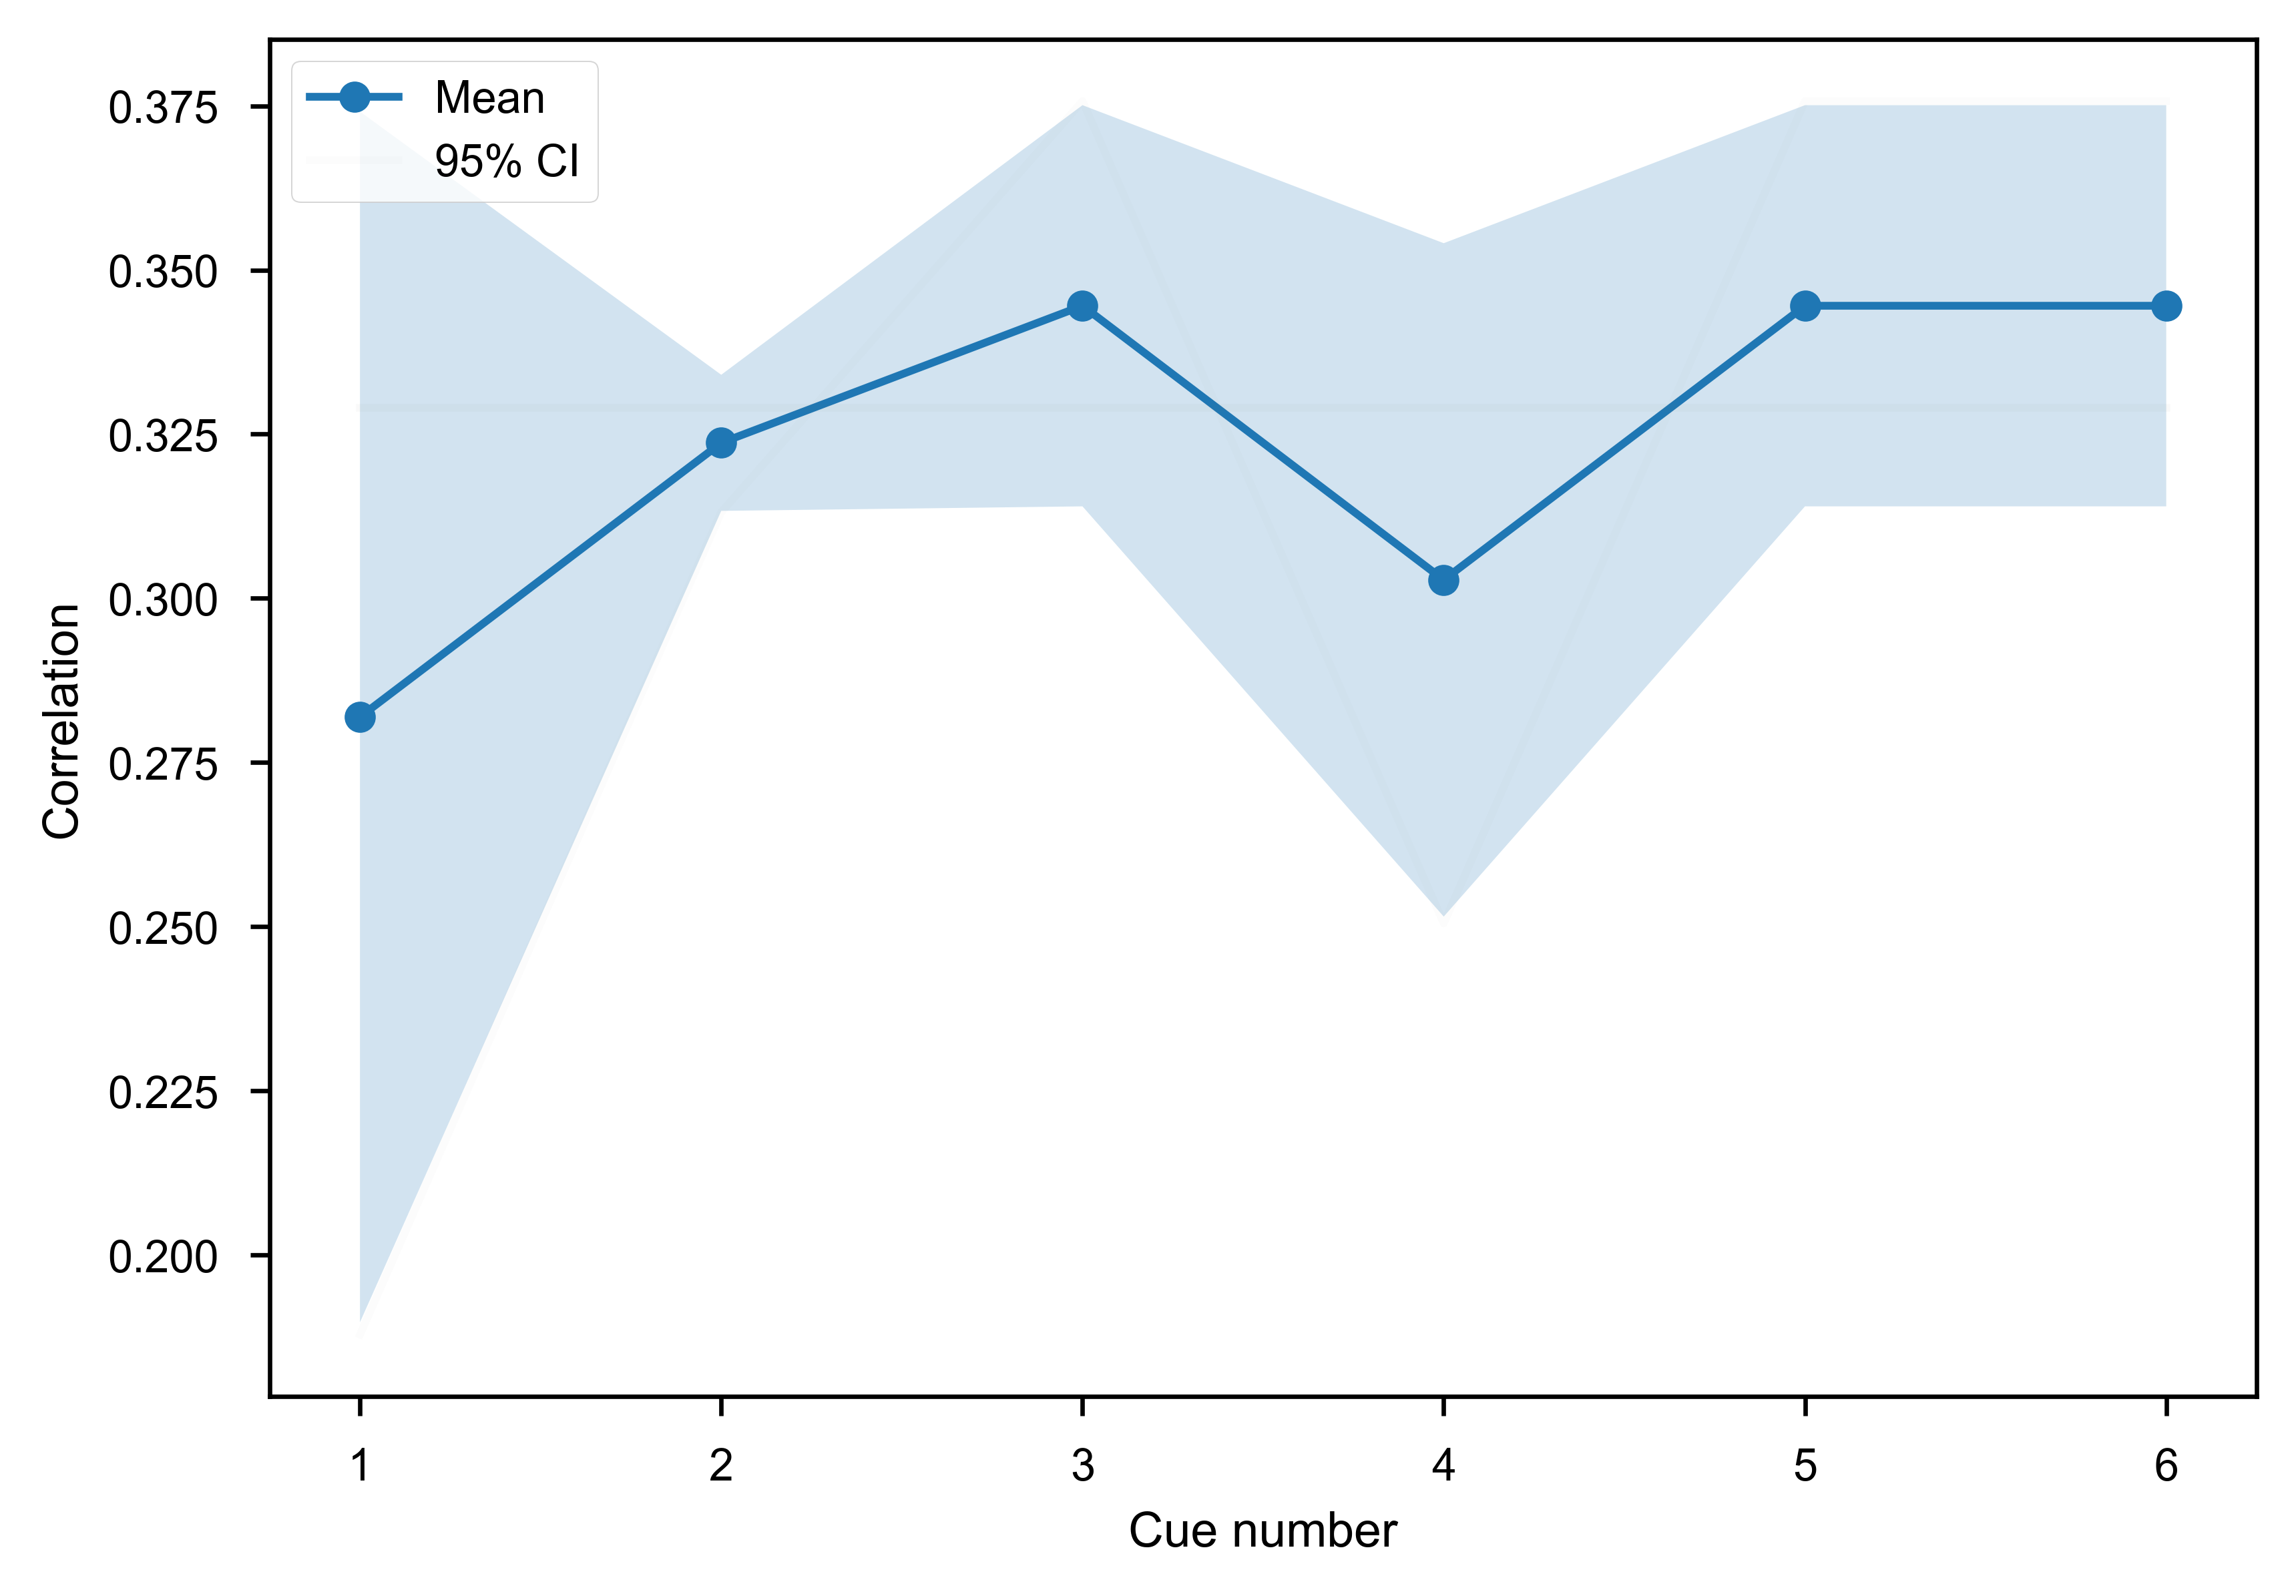

In [65]:
x = np.arange(seq_len) + 1
plt.plot(x, np.mean(correlations[:,good_indices], axis=1), '-o')
plt.plot(x, correlations[:,good_indices], color='gray', alpha=0.02)
# 95% CI
sem = scipy.stats.sem(correlations[:,good_indices], axis=1)
plt.fill_between(x, np.mean(correlations[:,good_indices], axis=1) - 1.96 * sem, np.mean(correlations[:,good_indices], axis=1) + 1.96 * sem, alpha=0.2)
plt.xlabel('Cue number')
plt.ylabel('Correlation')
plt.legend(['Mean', '95% CI'])